In [1]:
import os
import gc
import pandas as pd
import numpy as np
import lightgbm as lgbm
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
""" Load and process inputs """
input_dir = os.path.join(os.curdir, 'data')
print('Input files:\n{}'.format(os.listdir(input_dir)))
print('Loading data sets...')

Input files:
['bureau.csv', 'application_test.csv', 'processed_input_data.csv', 'credit_card_balance.csv', 'previous_application.csv', 'installments_payments.csv', 'bureau_balance.csv', 'POS_CASH_balance.csv', 'application_train.csv']
Loading data sets...


In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
sample_size = None
merged_df = reduce_mem_usage(pd.read_csv(os.path.join(input_dir, 'processed_input_data.csv'), nrows=sample_size))

Memory usage of dataframe is 1236.69 MB
Memory usage after optimization is: 494.68 MB
Decreased by 60.0%


In [5]:
# Separate metadata
meta_cols = ['SK_ID_CURR']
meta_df = merged_df[meta_cols]
merged_df.drop(columns=meta_cols, inplace=True)

In [6]:
def process_dataframe(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """

    # Label encode categoricals
    print('Label encoding categorical features...')
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    print('Label encoding complete.')

    return input_df, categorical_feats.tolist(), encoder_dict

In [7]:
categorical_feats = merged_df.columns[merged_df.dtypes == 'object']

In [8]:
categorical_feats

Index(['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START',
       'NAME_CONTRACT_TYPE_PRVMAX', 'WEEKDAY_APPR_PROCESS_START_PRVMAX',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY',
       'NAME_YIELD_GROUP', 'NAME_CONTRACT_TYPE_PRVMIN',
       'WEEKDAY_APPR_PROCESS_START_PRVMIN',
       'FLAG_LAST_APPL_PER_CONTRACT_PRVMIN', 'NAME_CASH_LOAN_PURPOSE_PRVMIN',
       'NAME_CONTRACT_STATUS_PRVMIN', 'NAME_PAYMENT_TYPE_PRVMIN',
       'CODE_REJECT_REASON_PRVMIN', 'NAME_

In [9]:
for feat in categorical_feats:
        encoder = LabelEncoder()
        merged_df[feat] = encoder.fit_transform(merged_df[feat].fillna('NULL'))

In [10]:
categorical_feats.tolist()

['CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_CONTRACT_TYPE_PRVMAX',
 'WEEKDAY_APPR_PROCESS_START_PRVMAX',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'NAME_CONTRACT_TYPE_PRVMIN',
 'WEEKDAY_APPR_PROCESS_START_PRVMIN',
 'FLAG_LAST_APPL_PER_CONTRACT_PRVMIN',
 'NAME_CASH_LOAN_PURPOSE_PRVMIN',
 'NAME_CONTRACT_STATUS_PRVMIN',
 'NAME_PAYMENT_TYPE_PRVMIN',
 'CODE_REJECT_REASON_PRVMIN',
 'NAME_CLIENT_TYPE_PRVMIN',
 'NAME_GOODS_CATEGORY_PRVMIN',
 'NAME_PORTFOLI

In [14]:
# Capture other categorical features not as object data types:
non_obj_categoricals = [
    'FONDKAPREMONT_MODE', 'HOUR_APPR_PROCESS_START', 'HOUSETYPE_MODE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'STATUS', 'NAME_CONTRACT_STATUS_CAVG',
    'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE_BAVG',
    'WEEKDAY_APPR_PROCESS_START_BAVG', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 
    'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE_BAVG', 
    'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 
    'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 
    'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'NAME_CONTRACT_STATUS_CCAVG',
    'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'
]
categorical_feats = categorical_feats.tolist() + non_obj_categoricals

In [15]:
# Re-separate into train and test
len_train = 307511
train_df = merged_df[:len_train]
test_df = merged_df[len_train:]
#del merged_df

In [16]:
""" Train the LightGBM model """
target = train_df.pop('TARGET')
test_df.drop(columns='TARGET', inplace=True)
lgbm_train = lgbm.Dataset(data=train_df,
                          label=target,
                          categorical_feature=categorical_feats,
                          free_raw_data=False)
                          
lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.02
}

cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=600,
                     early_stopping_rounds=50,
                     stratified=True,
                     verbose_eval=50,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best LGBM CV result = {}'.format(np.max(cv_results['auc-mean'])))


[50]	cv_agg's auc: 0.772069 + 0.00297116
[100]	cv_agg's auc: 0.781829 + 0.00263105
[150]	cv_agg's auc: 0.784977 + 0.00223466
[200]	cv_agg's auc: 0.787312 + 0.00196398
[250]	cv_agg's auc: 0.788391 + 0.0019868
[300]	cv_agg's auc: 0.789125 + 0.00196343
[350]	cv_agg's auc: 0.789468 + 0.0018412
[400]	cv_agg's auc: 0.789979 + 0.00180818
[450]	cv_agg's auc: 0.790285 + 0.00169092
[500]	cv_agg's auc: 0.79021 + 0.00176743
Optimum boost rounds = 468
Best LGBM CV result = 0.7903503896543542


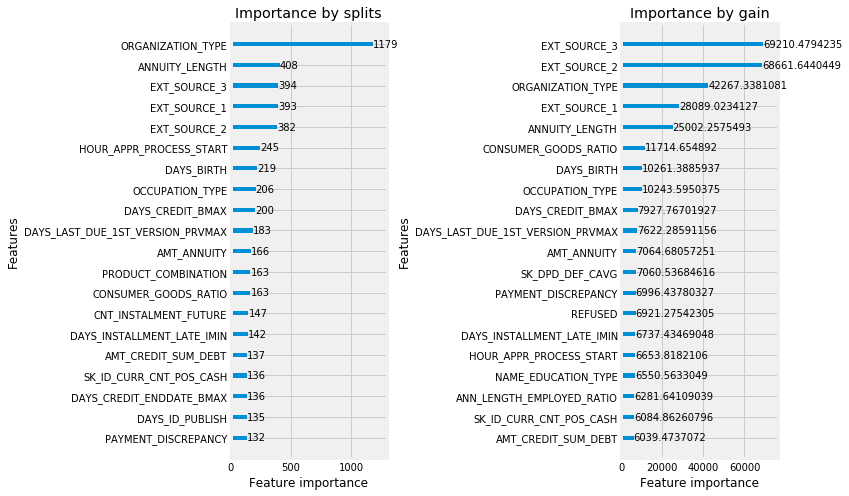

In [17]:
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)
                 
""" Predict on test set and create submission """
y_pred = clf.predict(test_df)
out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
out_df.to_csv('submission.csv', index=False)

# Plot importances
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[11, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.savefig('feature_importance.png')